In [1]:
import warnings
warnings.filterwarnings("ignore")

from unsloth import FastLanguageModel
import torch

from multiprocessing import cpu_count
num_proc = cpu_count()

import yaml

from data_processor import SplittedJsonIoDataset
from customs import customize_tokenizer

from unsloth import UnslothTrainer, UnslothTrainingArguments

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

from unsloth.chat_templates import train_on_responses_only

from unsloth import unsloth_train

from utils import save_log_history

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
with open("config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

model, tokenizer = FastLanguageModel.from_pretrained(
    **config["model_loading_args"]
)

model, tokenizer = customize_tokenizer(model, tokenizer, config)

==((====))==  Unsloth 2025.3.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA GeForce RTX 4070 Laptop GPU. Num GPUs = 1. Max memory: 7.996 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.6.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [3]:
# Create dataset for training
dataset = SplittedJsonIoDataset(tokenizer, config["system_message"]).create()

In [4]:
# Add LoRA weights
model = FastLanguageModel.get_peft_model(
    model=model,
    **config["lora_parameters"]
)

Unsloth: Offloading output_embeddings to disk to save VRAM


Unsloth 2025.3.15 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Unsloth: Training lm_head in mixed precision to save VRAM


In [5]:
# Select data collator
if config["fine_tuning_args"]["training_type"]=="text_completion":
    _train_on_responses_only_bool = True
    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)
elif config["fine_tuning_args"]["training_type"]=="continued_pre_training":
    _train_on_responses_only_bool = False
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
else:
    raise Exception("Wrong Training Type. Check config.yaml")

In [6]:
# Initiate trainer
trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    data_collator = data_collator,
    dataset_text_field = "text",
    max_seq_length = config["model_loading_args"]["max_seq_length"], # Used only when packing=True for creating a ConstantLengthDataset.
    packing = config["sft_trainer_arguments"]["apply_packing"],
    dataset_num_proc = 1,
    args = UnslothTrainingArguments(
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        **config["training_arguments"]
    )
)

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"]: 100%|██████████| 16/16 [00:00<00:00, 529.63 examples/s]


Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"]: 100%|██████████| 2/2 [00:00<00:00, 324.01 examples/s]


In [7]:
# Wrap trainer for apply training using only the assistant part
if _train_on_responses_only_bool:
    trainer = train_on_responses_only(
        trainer,
        instruction_part = config["instruction_part"],
        response_part = config["response_part"]
    )

num_proc must be <= 16. Reducing num_proc to 16 for dataset of size 16.
Map (num_proc=16): 100%|██████████| 16/16 [00:09<00:00,  1.64 examples/s]
num_proc must be <= 2. Reducing num_proc to 2 for dataset of size 2.
Map (num_proc=2): 100%|██████████| 2/2 [00:04<00:00,  2.37s/ examples]


In [8]:
# Start training
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16 | Num Epochs = 20 | Total steps = 20
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 268,304,384/1,000,000,000 (26.83% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
1,0.632700,0.701711
2,0.632700,0.693681
3,0.625400,0.663370
4,0.595200,0.626405
5,0.559600,0.586706
6,0.522700,0.549079
7,0.487600,0.515882
8,0.456400,0.485715
9,0.427600,0.460038
10,0.403200,0.438349


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


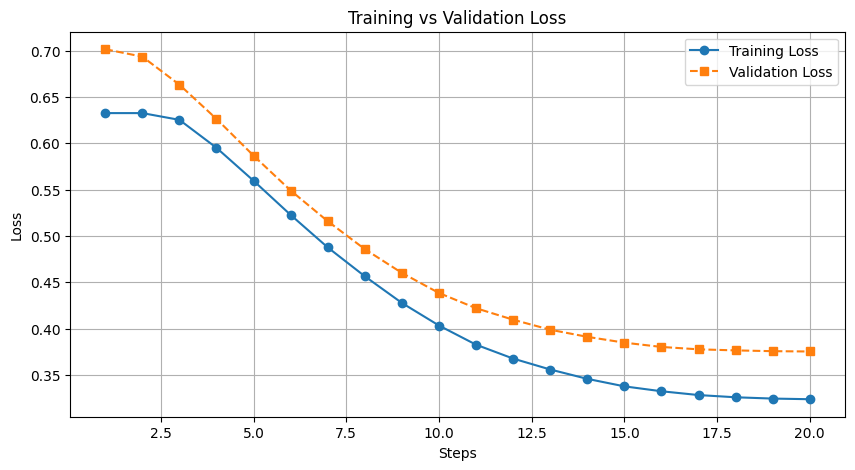

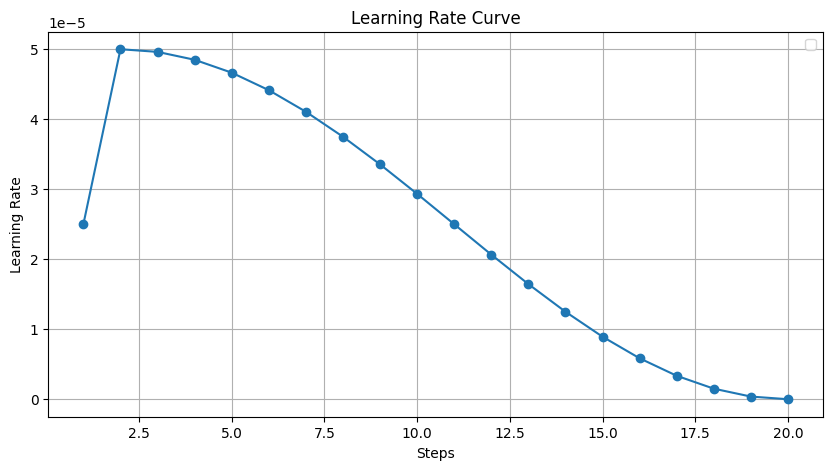

In [9]:
save_log_history(trainer)